In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import random


In [12]:
# Load dataset
df = pd.read_csv("cars_cleaned.csv")

# Extract numeric horsepower from 'engine' BEFORE dropping it
df["engine_hp"] = df["engine"].str.extract(r"(\d+\.?\d*)").astype(float)

# Calculate car age
df["model_year"] = pd.to_numeric(df["model_year"], errors="coerce")
df["car_age"] = 2025 - df["model_year"]

# Filter valid age range and remove outliers
df = df[(df["car_age"] > 0) & (df["car_age"] <= 15)]
df = df[df["price"] < df["price"].quantile(0.99)]
df = df[df["milage"] < df["milage"].quantile(0.99)]

# Drop rows with missing data in key columns
df = df.dropna(subset=["price", "engine", "engine_hp", "milage", "model_year"])

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Drop the raw engine text column now that we have engine_hp
df = df.drop(columns=["engine"])

# Encode categorical variables
df["brand"] = df["brand"].astype("category").cat.codes
df["model"] = df["model"].astype("category").cat.codes
df["fuel_type"] = df["fuel_type"].astype("category").cat.codes
df["ext_col"] = df["ext_col"].astype("category").cat.codes
df["int_col"] = df["int_col"].astype("category").cat.codes
df["accident"] = df["accident"].astype("category").cat.codes

# Log-transform the price
df["log_price"] = np.log1p(df["price"])

In [14]:
# Define features and target
features = ["brand", "model_year", "car_age", "milage", "fuel_type", "engine_hp", "accident"]
X = df[features]
y = df["log_price"]

# Confirm that data is ready
print(f"✅ Final dataset shape: {X.shape}")
print(df[["engine_hp", "price"]].head())

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

✅ Final dataset shape: (3074, 7)
   engine_hp   price
0      369.0   44500
1        3.8  131999
2      335.0   26500
3      304.0   20850
4        4.0   74900


In [17]:
# === Feature Engineering ===

# Try extracting horsepower only if 'engine' column is present
if "engine" in df.columns:
    df["engine_hp"] = df["engine"].str.extract(r"(\d+\.?\d*)").astype(float)
    df = df.drop(columns=["engine"])  # Drop only if it existed
else:
    print("⚠️ Skipping 'engine_hp' extraction: 'engine' column not found.")
    df["engine_hp"] = np.nan  # Create the column so later code doesn't break

# Calculate car age
df["car_age"] = 2025 - df["model_year"]


⚠️ Skipping 'engine_hp' extraction: 'engine' column not found.


### 📉 Depreciation Visualization by Car Age

In [18]:
# Average price by car age
avg_price_by_age = df.groupby("car_age")["price"].mean().reset_index()

fig = px.line(avg_price_by_age, x="car_age", y="price", title="Average Price by Car Age",
              labels={"car_age": "Car Age (Years)", "price": "Average Price (USD)"})
fig.show()


### 📊 Depreciation Trends by Fuel Type

In [28]:
# ✅ Map fuel_type numeric codes to actual labels
fuel_map = {
    0: "Diesel",
    1: "E85 Flex Fuel",
    2: "Gasoline",
    3: "Hybrid",
    4: "Plug-In Hybrid"
}

# Create a new column for fuel type labels
df["fuel_type_name"] = df["fuel_type"].map(fuel_map)

# ✅ Group by car age and readable fuel type
depreciation_by_fuel = df.groupby(["car_age", "fuel_type_name"])["price"].mean().reset_index()

# ✅ Plot depreciation trend
fig = px.line(depreciation_by_fuel, x="car_age", y="price", color="fuel_type_name",
              title="Depreciation by Car Age and Fuel Type",
              labels={
                  "car_age": "Car Age (Years)",
                  "price": "Average Price (USD)",
                  "fuel_type_name": "Fuel Type"
              })

fig.update_layout(legend_title="Fuel Type")
fig.show()


### 🔁 Price vs. Age by Mileage Bin

In [20]:
# Bin mileage into 6 groups and visualize
df["mileage_bin"] = pd.cut(df["milage"], bins=6)

depreciation_by_mileage = df.groupby(["car_age", "mileage_bin"])["price"].mean().reset_index()

fig = px.scatter(depreciation_by_mileage, x="car_age", y="price", color="mileage_bin",
                 title="Price vs. Age Grouped by Mileage Bin",
                 labels={"car_age": "Car Age", "price": "Avg Price"})
fig.show()


/var/folders/s5/_24hbnqd3t7c2zyc8pb1j61h0000gn/T/ipykernel_19144/3180854361.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [21]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=None, verbose=0)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)


In [22]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
}

# Run GridSearchCV
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring="r2",
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Best model predictions
best_rf = grid_search.best_estimator_
best_rf_pred = best_rf.predict(X_test)

# Evaluate
print("Best RF R²:", r2_score(y_test, best_rf_pred))
print("Best RF RMSE:", np.sqrt(mean_squared_error(y_test, best_rf_pred)))
print("Best Params:", grid_search.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best RF R²: 0.8513339180372708
Best RF RMSE: 0.2789258759110092
Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}


In [23]:
# Print R² and RMSE for each model
print(f"Linear Regression R²: {r2_score(y_test, lr_pred):.3f}, RMSE: {np.sqrt(mean_squared_error(y_test, lr_pred)):.2f}")
print(f"Random Forest R²: {r2_score(y_test, rf_pred):.3f}, RMSE: {np.sqrt(mean_squared_error(y_test, rf_pred)):.2f}")
print(f"Gradient Boosting R²: {r2_score(y_test, gb_pred):.3f}, RMSE: {np.sqrt(mean_squared_error(y_test, gb_pred)):.2f}")


Linear Regression R²: 0.625, RMSE: 0.44
Random Forest R²: 0.854, RMSE: 0.28
Gradient Boosting R²: 0.850, RMSE: 0.28


In [24]:
# Evaluate models
lr_r2 = r2_score(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

rf_r2 = r2_score(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

gb_r2 = r2_score(y_test, gb_pred)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))

# Comparison plot
comparison_df = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting"],
    "R2 Score": [lr_r2, rf_r2, gb_r2],
    "RMSE (USD)": [lr_rmse, rf_rmse, gb_rmse]
})

plot_df = comparison_df.melt(id_vars="Model", value_name="Score")

fig = px.bar(plot_df, x="Model", y="Score", color="variable", barmode="group",
             title="Model Performance Comparison (R² and RMSE)")
fig.update_layout(yaxis_title="Score", yaxis_tickformat=".2f")
fig.show()


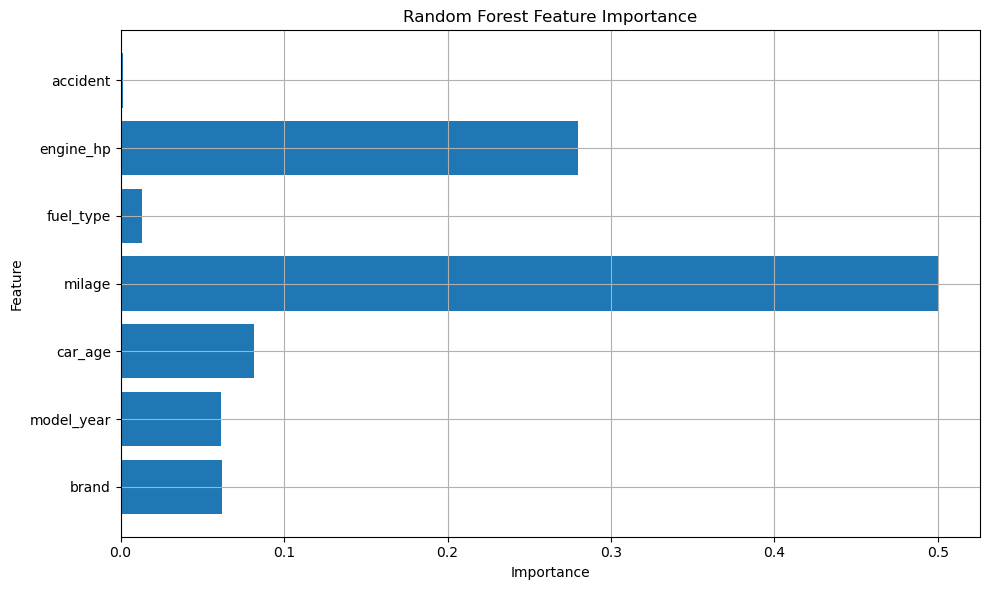

In [25]:
# Feature importance (Random Forest)
importances = rf_model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()
